In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from scipy import interp

from helpers import train_plot_roc

import matplotlib; matplotlib.rcParams.update({'font.size': 14})

data_folder = '../data/csv_data/'
extension = '.csv.gz'
build_path = lambda x: data_folder + x + extension

In [2]:
file_info = pd.read_csv(build_path('malwr_file_info_filtered')).set_index('link')
big_dataset = pd.read_csv(build_path('all_samples')).set_index('link')
big_dataset = big_dataset.join(file_info.start_time, how='left').dropna(subset=['start_time']).sort_values('start_time')
big_dataset.drop('start_time', axis=1, inplace=True)

In [3]:
strict_data = pd.read_csv(build_path('strict_dataset')).set_index('link')
loose_data = pd.read_csv(build_path('loose_dataset')).set_index('link')
real_data = pd.read_csv(build_path('real_dataset')).set_index('link')

# Strict Dataset

25119

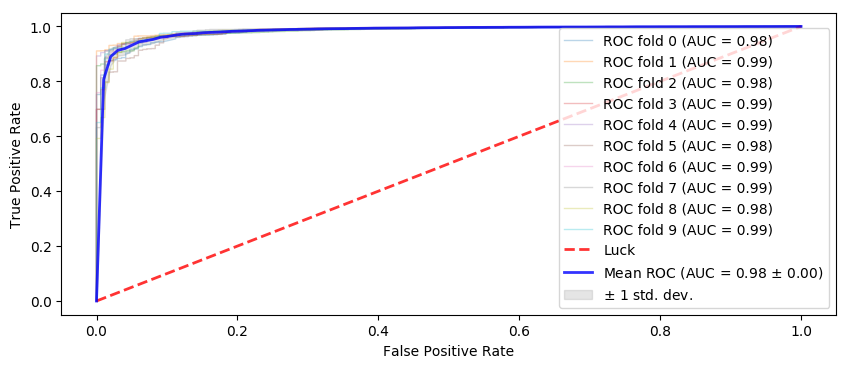

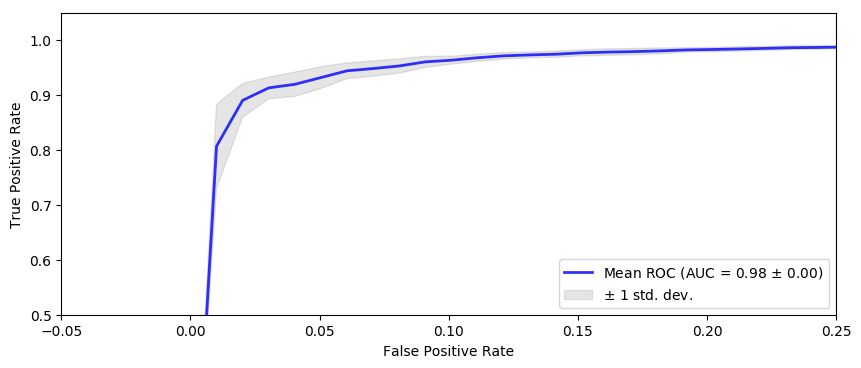

CPU times: user 47.3 s, sys: 7.2 s, total: 54.5 s
Wall time: 46.8 s


In [4]:
%%time
data = big_dataset[big_dataset.index.isin(strict_data.index)]
display(len(data))
data = shuffle(data)
(strict_fpr, strict_tpr, _) = train_plot_roc(np.array(data.drop('malware', axis=1)), data.malware)

# Loose Dataset

44593

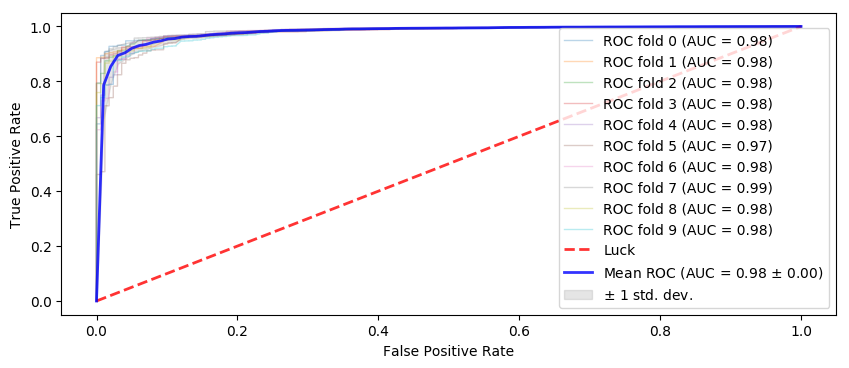

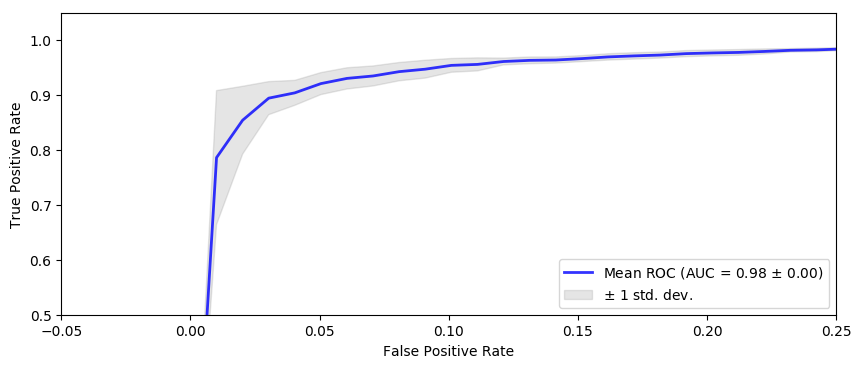

CPU times: user 1min 31s, sys: 7.16 s, total: 1min 39s
Wall time: 1min 31s


In [5]:
%%time
data = big_dataset[big_dataset.index.isin(loose_data.index)]
display(len(data))
data = shuffle(data)
(loose_fpr, loose_tpr, _) = train_plot_roc(np.array(data.drop('malware', axis=1)), data.malware)

# Real Dataset

122091

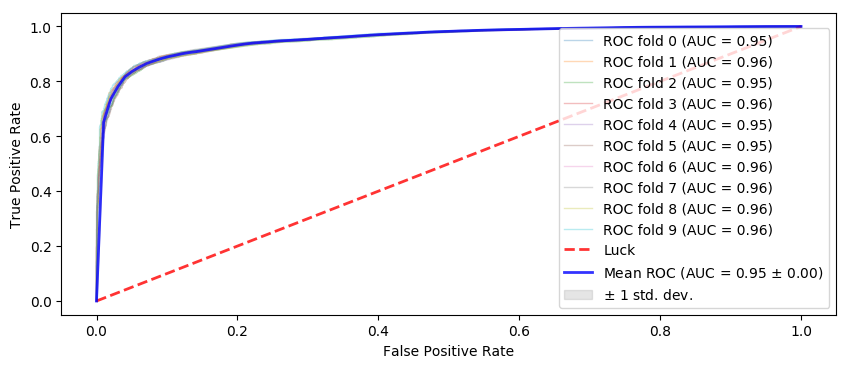

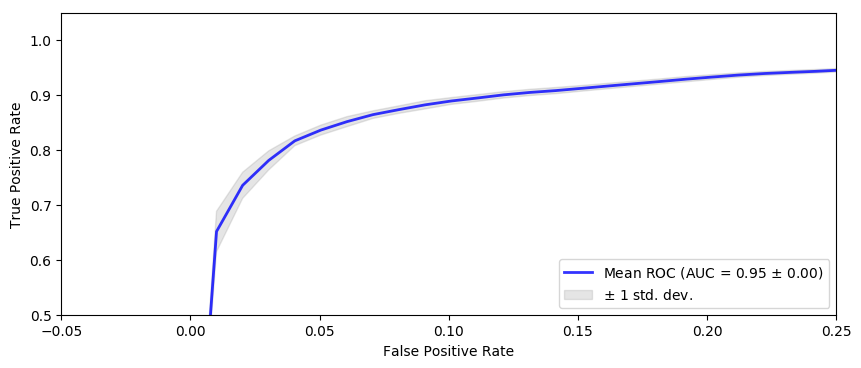

CPU times: user 7min 4s, sys: 9.09 s, total: 7min 13s
Wall time: 7min 7s


In [8]:
%%time
data = big_dataset[big_dataset.index.isin(real_data.index)]
display(len(data))
data = shuffle(data)
(real_fpr, real_tpr, _) = train_plot_roc(np.array(data.drop('malware', axis=1)), data.malware)

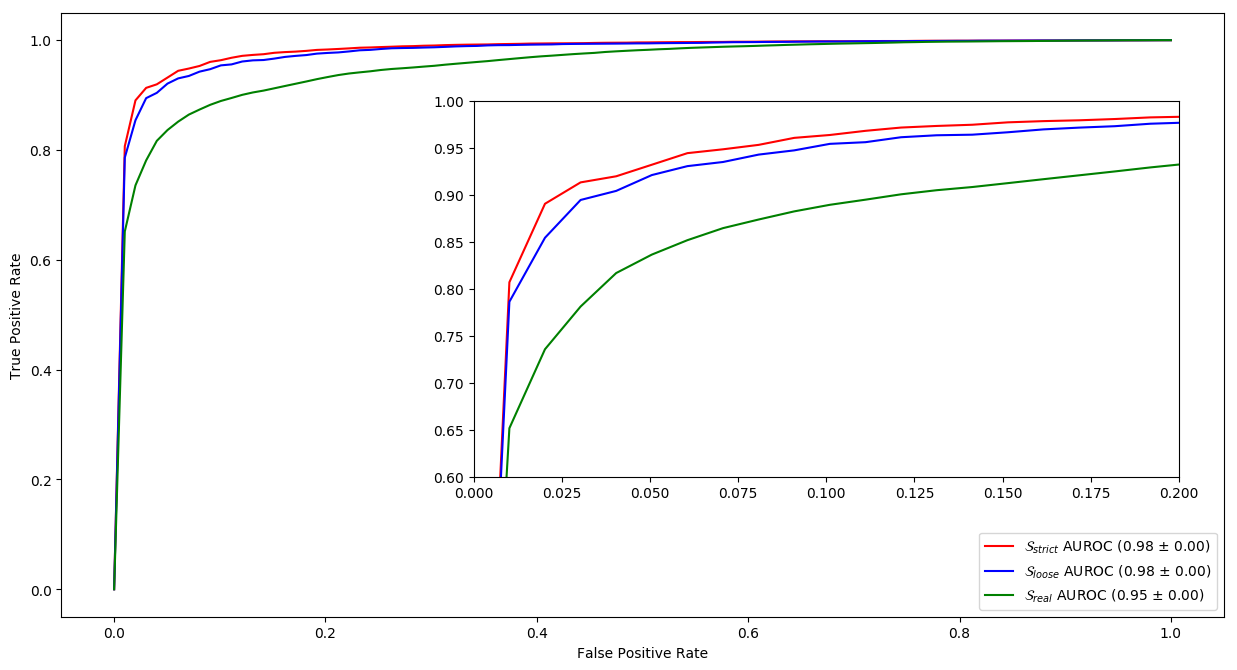

In [28]:
plt.figure(figsize=(15, 8), dpi=100)
plt.plot(strict_fpr, strict_tpr, color='r',
         label='$\mathcal{S}_{strict}$ AUROC (0.98 $\pm$ 0.00)')
plt.plot(loose_fpr, loose_tpr, color='b',
         label='$\mathcal{S}_{loose}$ AUROC (0.98 $\pm$ 0.00)')
plt.plot(real_fpr, real_tpr, color='g',
         label='$\mathcal{S}_{real}$ AUROC (0.95 $\pm$ 0.00)')
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
a = plt.axes([0.4, .3, .47, .47])
plt.ylim((0.6, 1.0))
plt.xlim((0.0, 0.2))
plt.plot(strict_fpr, strict_tpr, color='r')
plt.plot(loose_fpr, loose_tpr, color='b')
plt.plot(real_fpr, real_tpr, color='g')
plt.show()

# Strict Dataset Past-to-Present

In [29]:
auc_frame = []

In [30]:
data = big_dataset[big_dataset.index.isin(strict_data.index)]
display(len(data))

# Split dataset into fixed test and training
split_position = len(data) - int(len(data) * 0.1)
training_set = data[:split_position]
test_set = data[split_position:]

# Split into 10 training folds
train_size = int(len(training_set) / 10)

display('Training set: {}'.format(len(training_set)))
display('Test set: {}'.format(len(test_set)))

25119

'Training set: 22608'

'Test set: 2511'

In [31]:
%%time
tprs = []
aucs = []

mean_fpr = np.linspace(0, 1, 100)
classifier = LogisticRegression(C=1)

x_test = test_set.drop('malware', axis=1)
y_test = test_set.malware
for i in range(10):
    fold_size = i*train_size + train_size
    x_training = training_set[:fold_size].drop('malware', axis=1)
    y_training = training_set[:fold_size].malware
    
    nmalware = len(y_training[y_training == True])
    ngoodware = len(y_training[y_training == False])
    
    probas_ = classifier.fit(x_training, y_training).predict_proba(x_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    display('Fold {}; Goodware/Malware ratio: {:.2f}, AUROC: {:.2f}'.format(i, ngoodware/nmalware, roc_auc))
    i += 1

auc_frame.append(aucs)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)    

'Fold 0; Goodware/Malware ratio: 0.16, AUROC: 0.94'

'Fold 1; Goodware/Malware ratio: 0.08, AUROC: 0.96'

'Fold 2; Goodware/Malware ratio: 0.05, AUROC: 0.97'

'Fold 3; Goodware/Malware ratio: 0.04, AUROC: 0.96'

'Fold 4; Goodware/Malware ratio: 0.03, AUROC: 0.95'

'Fold 5; Goodware/Malware ratio: 0.04, AUROC: 0.96'

'Fold 6; Goodware/Malware ratio: 0.04, AUROC: 0.97'

'Fold 7; Goodware/Malware ratio: 0.04, AUROC: 0.97'

'Fold 8; Goodware/Malware ratio: 0.04, AUROC: 0.97'

'Fold 9; Goodware/Malware ratio: 0.04, AUROC: 0.98'

CPU times: user 22.6 s, sys: 5.5 s, total: 28.1 s
Wall time: 22.2 s


# Loose Dataset Past-to-Present

In [32]:
data = big_dataset[big_dataset.index.isin(loose_data.index)]
display(len(data))

# Split dataset into fixed test and training
split_position = len(data) - int(len(data) * 0.1)
training_set = data[:split_position]
test_set = data[split_position:]

# Split into 10 training folds
train_size = int(len(training_set) / 10)

display('Training set: {}'.format(len(training_set)))
display('Test set: {}'.format(len(test_set)))

44593

'Training set: 40134'

'Test set: 4459'

In [33]:
%%time
tprs = []
aucs = []

mean_fpr = np.linspace(0, 1, 100)
classifier = LogisticRegression(C=1)

x_test = test_set.drop('malware', axis=1)
y_test = test_set.malware
for i in range(10):
    fold_size = i*train_size + train_size
    x_training = training_set[:fold_size].drop('malware', axis=1)
    y_training = training_set[:fold_size].malware
    
    nmalware = len(y_training[y_training == True])
    ngoodware = len(y_training[y_training == False])
    
    probas_ = classifier.fit(x_training, y_training).predict_proba(x_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    display('Fold {}; Goodware/Malware ratio: {:.2f}, AUROC: {:.2f}'.format(i, ngoodware/nmalware, roc_auc))
    i += 1

auc_frame.append(aucs)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)    

'Fold 0; Goodware/Malware ratio: 0.07, AUROC: 0.94'

'Fold 1; Goodware/Malware ratio: 0.04, AUROC: 0.94'

'Fold 2; Goodware/Malware ratio: 0.03, AUROC: 0.96'

'Fold 3; Goodware/Malware ratio: 0.02, AUROC: 0.95'

'Fold 4; Goodware/Malware ratio: 0.02, AUROC: 0.95'

'Fold 5; Goodware/Malware ratio: 0.02, AUROC: 0.96'

'Fold 6; Goodware/Malware ratio: 0.02, AUROC: 0.96'

'Fold 7; Goodware/Malware ratio: 0.02, AUROC: 0.97'

'Fold 8; Goodware/Malware ratio: 0.02, AUROC: 0.97'

'Fold 9; Goodware/Malware ratio: 0.02, AUROC: 0.98'

CPU times: user 48.8 s, sys: 5.99 s, total: 54.8 s
Wall time: 48.7 s


# Real Dataset Past-to-Present

In [35]:
data = big_dataset[big_dataset.index.isin(real_data.index)]
display(len(data))

# Split dataset into fixed test and training
split_position = len(data) - int(len(data) * 0.1)
training_set = data[:split_position]
test_set = data[split_position:]

# Split into 10 training folds
train_size = int(len(training_set) / 10)

display('Training set: {}'.format(len(training_set)))
display('Test set: {}'.format(len(test_set)))

122091

'Training set: 109882'

'Test set: 12209'

In [36]:
%%time
tprs = []
aucs = []

mean_fpr = np.linspace(0, 1, 100)
classifier = LogisticRegression(C=1)

x_test = test_set.drop('malware', axis=1)
y_test = test_set.malware
for i in range(10):
    fold_size = i*train_size + train_size
    x_training = training_set[:fold_size].drop('malware', axis=1)
    y_training = training_set[:fold_size].malware
    
    nmalware = len(y_training[y_training == True])
    ngoodware = len(y_training[y_training == False])
    
    probas_ = classifier.fit(x_training, y_training).predict_proba(x_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    display('Fold {}; Goodware/Malware ratio: {:.2f}, AUROC: {:.2f}'.format(i, ngoodware/nmalware, roc_auc))
    i += 1

auc_frame.append(aucs)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)    

'Fold 0; Goodware/Malware ratio: 0.35, AUROC: 0.82'

'Fold 1; Goodware/Malware ratio: 0.29, AUROC: 0.90'

'Fold 2; Goodware/Malware ratio: 0.23, AUROC: 0.90'

'Fold 3; Goodware/Malware ratio: 0.19, AUROC: 0.90'

'Fold 4; Goodware/Malware ratio: 0.20, AUROC: 0.93'

'Fold 5; Goodware/Malware ratio: 0.21, AUROC: 0.94'

'Fold 6; Goodware/Malware ratio: 0.20, AUROC: 0.95'

'Fold 7; Goodware/Malware ratio: 0.23, AUROC: 0.95'

'Fold 8; Goodware/Malware ratio: 0.24, AUROC: 0.95'

'Fold 9; Goodware/Malware ratio: 0.27, AUROC: 0.95'

CPU times: user 3min 44s, sys: 8.39 s, total: 3min 53s
Wall time: 3min 47s


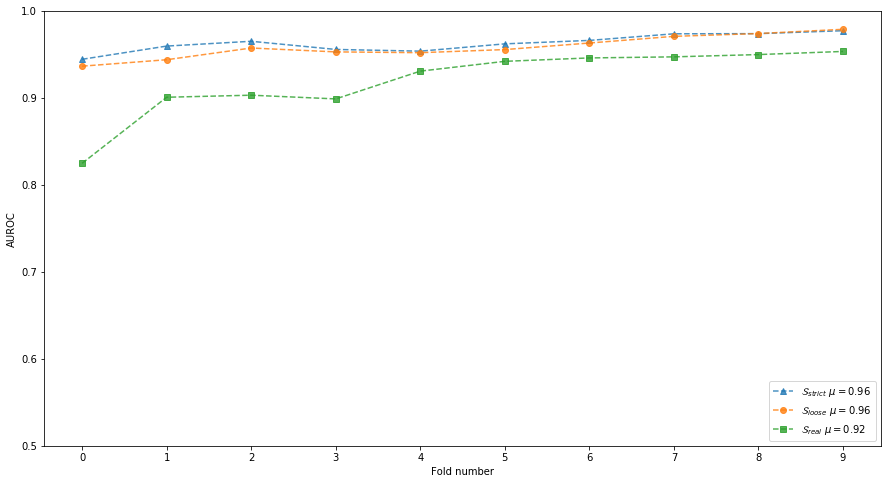

In [42]:
test = pd.DataFrame(auc_frame)
test.index = ['$\mathcal{S}_{strict}$ $\mu=0.96$', '$\mathcal{S}_{loose}$ $\mu=0.96$', '$\mathcal{S}_{real}$ $\mu=0.92$']
test = test.transpose()
ax = test.plot.line(figsize=(15, 8), style=['^', 'o', 's'], linestyle='--', alpha=0.8)
plt.ylim([0.5, 1.])
plt.xticks(range(10))
plt.ylabel('AUROC')
plt.xlabel('Fold number')
plt.legend(loc='lower right')
plt.show()

In [40]:
test.describe()

,$\mathcal{S}_{strict}$ $\mu=0.96$,$\mathcal{S}_{loose}$ $\mu=0.96$,$\mathcal{S}_{real}$ $\mu=0.92$
count,10.000000,10.000000,10.000000
mean,0.963157,0.958486,0.919663
std,0.010259,0.013369,0.039706
min,0.944383,0.936476,0.824782
25%,0.956683,0.952210,0.901334
50%,0.963612,0.956455,0.936406
75%,0.971794,0.968848,0.946874
max,0.977241,0.978852,0.953412


# Strict Dataset Present-to-Past

In [43]:
auc_frame = []

In [44]:
data = big_dataset[big_dataset.index.isin(strict_data.index)]
display(len(data))

# Split dataset into fixed test and training
split_position = len(data) - int(len(data) * 0.1)
training_set = data[:split_position][::-1]
test_set = data[split_position:]

# Split into 10 training folds
train_size = int(len(training_set) / 10)

display('Training set: {}'.format(len(training_set)))
display('Test set: {}'.format(len(test_set)))

25119

'Training set: 22608'

'Test set: 2511'

In [45]:
%%time
tprs = []
aucs = []

mean_fpr = np.linspace(0, 1, 100)
classifier = LogisticRegression(C=1)

x_test = test_set.drop('malware', axis=1)
y_test = test_set.malware
for i in range(10):
    fold_size = i*train_size + train_size
    x_training = training_set[:fold_size].drop('malware', axis=1)
    y_training = training_set[:fold_size].malware
    
    nmalware = len(y_training[y_training == True])
    ngoodware = len(y_training[y_training == False])
    
    probas_ = classifier.fit(x_training, y_training).predict_proba(x_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    display('Fold {}; Goodware/Malware ratio: {:.2f}, AUROC: {:.2f}'.format(i, ngoodware/nmalware, roc_auc))
    i += 1

auc_frame.append(aucs)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)    

'Fold 0; Goodware/Malware ratio: 0.06, AUROC: 0.96'

'Fold 1; Goodware/Malware ratio: 0.07, AUROC: 0.97'

'Fold 2; Goodware/Malware ratio: 0.05, AUROC: 0.98'

'Fold 3; Goodware/Malware ratio: 0.04, AUROC: 0.98'

'Fold 4; Goodware/Malware ratio: 0.05, AUROC: 0.98'

'Fold 5; Goodware/Malware ratio: 0.04, AUROC: 0.98'

'Fold 6; Goodware/Malware ratio: 0.04, AUROC: 0.98'

'Fold 7; Goodware/Malware ratio: 0.03, AUROC: 0.98'

'Fold 8; Goodware/Malware ratio: 0.03, AUROC: 0.98'

'Fold 9; Goodware/Malware ratio: 0.04, AUROC: 0.98'

CPU times: user 26.5 s, sys: 5.34 s, total: 31.8 s
Wall time: 25.8 s


# Loose Dataset Present-to-Past

In [46]:
data = big_dataset[big_dataset.index.isin(loose_data.index)]
display(len(data))

# Split dataset into fixed test and training
split_position = len(data) - int(len(data) * 0.1)
training_set = data[:split_position][::-1]
test_set = data[split_position:]

# Split into 10 training folds
train_size = int(len(training_set) / 10)

display('Training set: {}'.format(len(training_set)))
display('Test set: {}'.format(len(test_set)))

44593

'Training set: 40134'

'Test set: 4459'

In [47]:
%%time
tprs = []
aucs = []

mean_fpr = np.linspace(0, 1, 100)
classifier = LogisticRegression(C=1)

x_test = test_set.drop('malware', axis=1)
y_test = test_set.malware
for i in range(10):
    fold_size = i*train_size + train_size
    x_training = training_set[:fold_size].drop('malware', axis=1)
    y_training = training_set[:fold_size].malware
    
    nmalware = len(y_training[y_training == True])
    ngoodware = len(y_training[y_training == False])
    
    probas_ = classifier.fit(x_training, y_training).predict_proba(x_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    display('Fold {}; Goodware/Malware ratio: {:.2f}, AUROC: {:.2f}'.format(i, ngoodware/nmalware, roc_auc))
    i += 1

auc_frame.append(aucs)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)    

'Fold 0; Goodware/Malware ratio: 0.06, AUROC: 0.97'

'Fold 1; Goodware/Malware ratio: 0.04, AUROC: 0.98'

'Fold 2; Goodware/Malware ratio: 0.03, AUROC: 0.98'

'Fold 3; Goodware/Malware ratio: 0.03, AUROC: 0.98'

'Fold 4; Goodware/Malware ratio: 0.03, AUROC: 0.98'

'Fold 5; Goodware/Malware ratio: 0.02, AUROC: 0.98'

'Fold 6; Goodware/Malware ratio: 0.02, AUROC: 0.98'

'Fold 7; Goodware/Malware ratio: 0.02, AUROC: 0.98'

'Fold 8; Goodware/Malware ratio: 0.02, AUROC: 0.98'

'Fold 9; Goodware/Malware ratio: 0.02, AUROC: 0.98'

CPU times: user 47 s, sys: 5.69 s, total: 52.7 s
Wall time: 46.9 s


# Real Dataset Present-to-Past

In [48]:
data = big_dataset[big_dataset.index.isin(real_data.index)]
display(len(data))

# Split dataset into fixed test and training
split_position = len(data) - int(len(data) * 0.1)
training_set = data[:split_position][::-1]
test_set = data[split_position:]

# Split into 10 training folds
train_size = int(len(training_set) / 10)

display('Training set: {}'.format(len(training_set)))
display('Test set: {}'.format(len(test_set)))

122091

'Training set: 109882'

'Test set: 12209'

In [49]:
%%time
tprs = []
aucs = []

mean_fpr = np.linspace(0, 1, 100)
classifier = LogisticRegression(C=1)

x_test = test_set.drop('malware', axis=1)
y_test = test_set.malware
for i in range(10):
    fold_size = i*train_size + train_size
    x_training = training_set[:fold_size].drop('malware', axis=1)
    y_training = training_set[:fold_size].malware
    
    nmalware = len(y_training[y_training == True])
    ngoodware = len(y_training[y_training == False])
    
    probas_ = classifier.fit(x_training, y_training).predict_proba(x_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    display('Fold {}; Goodware/Malware ratio: {:.2f}, AUROC: {:.2f}'.format(i, ngoodware/nmalware, roc_auc))
    i += 1

auc_frame.append(aucs)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)    

'Fold 0; Goodware/Malware ratio: 0.58, AUROC: 0.96'

'Fold 1; Goodware/Malware ratio: 0.48, AUROC: 0.96'

'Fold 2; Goodware/Malware ratio: 0.46, AUROC: 0.96'

'Fold 3; Goodware/Malware ratio: 0.38, AUROC: 0.96'

'Fold 4; Goodware/Malware ratio: 0.35, AUROC: 0.96'

'Fold 5; Goodware/Malware ratio: 0.33, AUROC: 0.96'

'Fold 6; Goodware/Malware ratio: 0.29, AUROC: 0.96'

'Fold 7; Goodware/Malware ratio: 0.27, AUROC: 0.96'

'Fold 8; Goodware/Malware ratio: 0.26, AUROC: 0.95'

'Fold 9; Goodware/Malware ratio: 0.27, AUROC: 0.95'

CPU times: user 3min 55s, sys: 8.21 s, total: 4min 3s
Wall time: 3min 57s


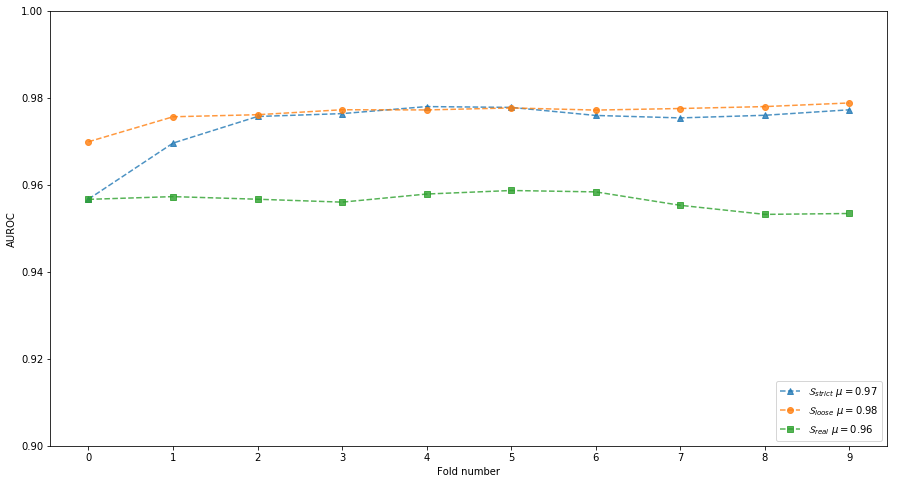

In [53]:
test = pd.DataFrame(auc_frame)
test.index = ['$\mathcal{S}_{strict}$ $\mu=0.97$', '$\mathcal{S}_{loose}$ $\mu=0.98$', '$\mathcal{S}_{real}$ $\mu=0.96$']
test = test.transpose()
ax = test.plot.line(figsize=(15, 8), style=['^', 'o', 's'], linestyle='--', alpha=0.8)
plt.ylim([0.9, 1.])
plt.xticks(range(10))
plt.ylabel('AUROC')
plt.xlabel('Fold number')
plt.legend(loc='lower right')
plt.show()

In [51]:
test.describe()

,$\mathcal{S}_{strict}$ $\mu=0.90$,$\mathcal{S}_{loose}$ $\mu=0.90$,$\mathcal{S}_{real}$ $\mu=0.69$
count,10.000000,10.000000,10.000000
mean,0.973889,0.976551,0.956361
std,0.006475,0.002495,0.001910
min,0.956724,0.969919,0.953215
25%,0.975479,0.976401,0.955482
50%,0.975984,0.977254,0.956684
75%,0.977044,0.977660,0.957745
max,0.978003,0.978838,0.958706


# Strict Dataset Sliding Window

In [54]:
final_rocs = []

In [55]:
data = big_dataset[big_dataset.index.isin(strict_data.index)]
display(len(data))

fold_size = test_size = int(len(data) / 10)
train_size = fold_size * 3


display('Training set: {}'.format(train_size))
display('Test set: {}'.format(test_size))

25119

'Training set: 7533'

'Test set: 2511'

In [56]:
%%time
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

start = 0
for i in range(7):
    training_set = data[start:start+train_size]
    test_set = data[start+train_size:start+train_size+test_size]
    
    start += fold_size
     
    x_training = training_set.drop('malware', axis=1)
    y_training = training_set.malware
    x_test = test_set.drop('malware', axis=1)
    y_test = test_set.malware
    
    nmalware = len(y_training[y_training == True])
    ngoodware = len(y_training[y_training == False])
    
    probas_ = classifier.fit(x_training, y_training).predict_proba(x_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    display('Fold {}; Goodware/Malware ratio: {:.2f}, AUROC: {:.2f}'.format(i, ngoodware/nmalware, roc_auc))
    i += 1

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
    
final_rocs += [(mean_fpr, mean_tpr)]

'Fold 0; Goodware/Malware ratio: 0.05, AUROC: 0.96'

'Fold 1; Goodware/Malware ratio: 0.01, AUROC: 0.94'

'Fold 2; Goodware/Malware ratio: 0.02, AUROC: 0.97'

'Fold 3; Goodware/Malware ratio: 0.03, AUROC: 0.94'

'Fold 4; Goodware/Malware ratio: 0.04, AUROC: 0.95'

'Fold 5; Goodware/Malware ratio: 0.04, AUROC: 0.98'

'Fold 6; Goodware/Malware ratio: 0.05, AUROC: 0.98'

CPU times: user 9.49 s, sys: 3.19 s, total: 12.7 s
Wall time: 8.86 s


# Loose Dataset Sliding Window

In [57]:
data = big_dataset[big_dataset.index.isin(loose_data.index)]
display(len(data))

fold_size = test_size = int(len(data) / 10)
train_size = fold_size * 3


display('Training set: {}'.format(train_size))
display('Test set: {}'.format(test_size))

44593

'Training set: 13377'

'Test set: 4459'

In [58]:
%%time
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

start = 0
for i in range(7):
    training_set = data[start:start+train_size]
    test_set = data[start+train_size:start+train_size+test_size]
    
    start += fold_size
     
    x_training = training_set.drop('malware', axis=1)
    y_training = training_set.malware
    x_test = test_set.drop('malware', axis=1)
    y_test = test_set.malware
    
    nmalware = len(y_training[y_training == True])
    ngoodware = len(y_training[y_training == False])
    
    probas_ = classifier.fit(x_training, y_training).predict_proba(x_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    display('Fold {}; Goodware/Malware ratio: {:.2f}, AUROC: {:.2f}'.format(i, ngoodware/nmalware, roc_auc))
    i += 1
    
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
    
final_rocs += [(mean_fpr, mean_tpr)]

'Fold 0; Goodware/Malware ratio: 0.03, AUROC: 0.93'

'Fold 1; Goodware/Malware ratio: 0.01, AUROC: 0.90'

'Fold 2; Goodware/Malware ratio: 0.00, AUROC: 0.92'

'Fold 3; Goodware/Malware ratio: 0.02, AUROC: 0.93'

'Fold 4; Goodware/Malware ratio: 0.02, AUROC: 0.95'

'Fold 5; Goodware/Malware ratio: 0.02, AUROC: 0.98'

'Fold 6; Goodware/Malware ratio: 0.03, AUROC: 0.98'

CPU times: user 17.5 s, sys: 3.31 s, total: 20.8 s
Wall time: 17 s


# Real Dataset Sliding Window

In [59]:
data = big_dataset[big_dataset.index.isin(real_data.index)]
display(len(data))

fold_size = test_size = int(len(data) / 10)
train_size = fold_size * 3


display('Training set: {}'.format(train_size))
display('Test set: {}'.format(test_size))

122091

'Training set: 36627'

'Test set: 12209'

In [60]:
%%time
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

start = 0
for i in range(7):
    training_set = data[start:start+train_size]
    test_set = data[start+train_size:start+train_size+test_size]
    
    start += fold_size
     
    x_training = training_set.drop('malware', axis=1)
    y_training = training_set.malware
    x_test = test_set.drop('malware', axis=1)
    y_test = test_set.malware
    
    nmalware = len(y_training[y_training == True])
    ngoodware = len(y_training[y_training == False])
    
    probas_ = classifier.fit(x_training, y_training).predict_proba(x_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    display('Fold {}; Goodware/Malware ratio: {:.2f}, AUROC: {:.2f}'.format(i, ngoodware/nmalware, roc_auc))
    i += 1
    
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
    
final_rocs += [(mean_fpr, mean_tpr)]

'Fold 0; Goodware/Malware ratio: 0.21, AUROC: 0.96'

'Fold 1; Goodware/Malware ratio: 0.15, AUROC: 0.87'

'Fold 2; Goodware/Malware ratio: 0.16, AUROC: 0.95'

'Fold 3; Goodware/Malware ratio: 0.20, AUROC: 0.96'

'Fold 4; Goodware/Malware ratio: 0.24, AUROC: 0.96'

'Fold 5; Goodware/Malware ratio: 0.31, AUROC: 0.96'

'Fold 6; Goodware/Malware ratio: 0.42, AUROC: 0.96'

CPU times: user 1min 34s, sys: 4.56 s, total: 1min 39s
Wall time: 1min 35s


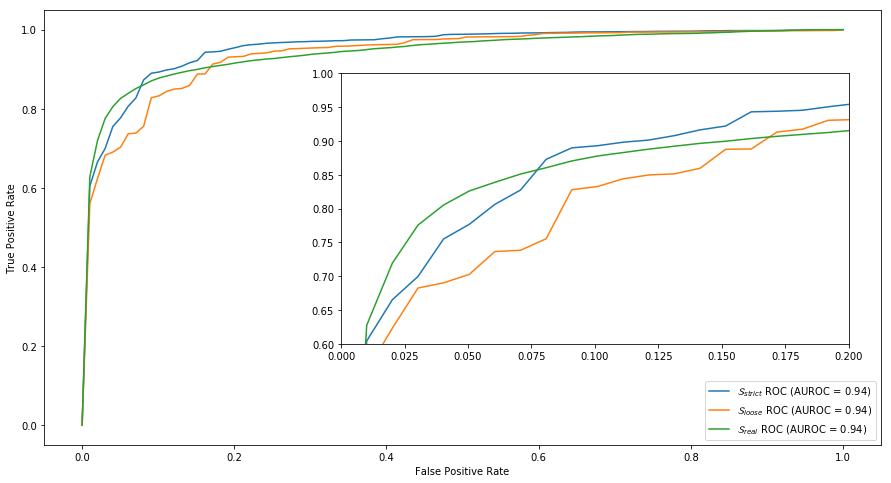

In [64]:
plt.figure(figsize=(15, 8))

strict_fpr, strict_tpr = final_rocs[0]
plt.plot(strict_fpr, strict_tpr, label='$\mathcal{S}_{strict}$ ROC (AUROC = %0.2f)' % (auc(fpr, tpr)))

loose_fpr, loose_tpr = final_rocs[1]
plt.plot(loose_fpr, loose_tpr, label='$\mathcal{S}_{loose}$ ROC (AUROC = %0.2f)' % (auc(fpr, tpr)))

real_fpr, real_tpr = final_rocs[2]
plt.plot(real_fpr, real_tpr, label='$\mathcal{S}_{real}$ ROC (AUROC = %0.2f)' % (auc(fpr, tpr)))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
a = plt.axes([0.4, .3, .47, .47])
plt.ylim((0.6, 1.0))
plt.xlim((0.0, 0.2))
plt.plot(strict_fpr, strict_tpr)
plt.plot(loose_fpr, loose_tpr)
plt.plot(real_fpr, real_tpr)
plt.show()

In [67]:
list(big_dataset.max())

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 5.19933758270342,
 5.19933758270342,
 5.19933758270342,
 5.19933758270342,
 5.19933758270342,
 5.19933758270342,
 5.19933758270342,
 5.19933758270342,
 5.19933758270342,
 5.19933758270342,
 5.19933758270342,
 5.19933758270342,
 5.19933758270342,
 5.19933758270342,
 5.19933758270342,
 5.19933758270342,
 5.19933758270342,
 5.19933758270342,
 5.19933758270342,
 5.19933758270342,
 5.19933758270342,
 5.19933758270342,
 5.19933758270342,
 5.19933758270342,
 5.19933758270342,
 5.19933758270342,
 5.19933758270342,
 5.19933758270342,
 5.19933758270342,
 5.19933758270342,
 5.19933758270342,
 5.19933758270342,
 5.19933758270